In [1]:
import pandas as pd #Analysis 
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis 
import warnings 

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import eli5
from eli5.sklearn import PermutationImportance

import shap

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/freestar/.local/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
%matplotlib inline
color = sns.color_palette()
warnings.filterwarnings('ignore')
plt.rcParams["figure.facecolor"] = 'w'
plt.rcParams["font.family"] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

In [3]:
train = pd.read_csv("../../data/jeju_financial_life_data.csv")
train.shape

(10422, 27)

#### 유니크 갯수 계산을 통한 변수 값의 다양성 분석

In [4]:
train_unique = []
for i in train.columns.values:
    train_unique.append(len(train[i].unique()))
unique_train = pd.DataFrame()
unique_train['Columns'] = list(train.columns)
unique_train['Unique_value'] = train_unique

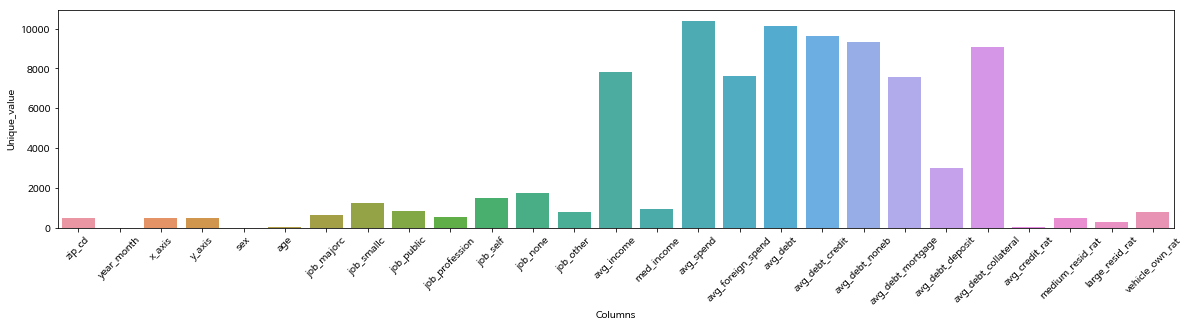

In [5]:
plt.figure(figsize=(20,4))
sns.barplot(unique_train['Columns'], unique_train['Unique_value'])
xt = plt.xticks()
_ = plt.xticks(xt[0], train.columns, rotation=45)

## 상관관계 분석
데이터 컬럼 사이의 상관관계를 계산해 비례함의 정도를 보인다.  
양의 상관관계가 클수록 비례관계, 음의 상관관계가 클수록 반비례 관계이며 0에 가까우면 서로 독립으로 볼 수 있다.

<function matplotlib.pyplot.show(*args, **kw)>

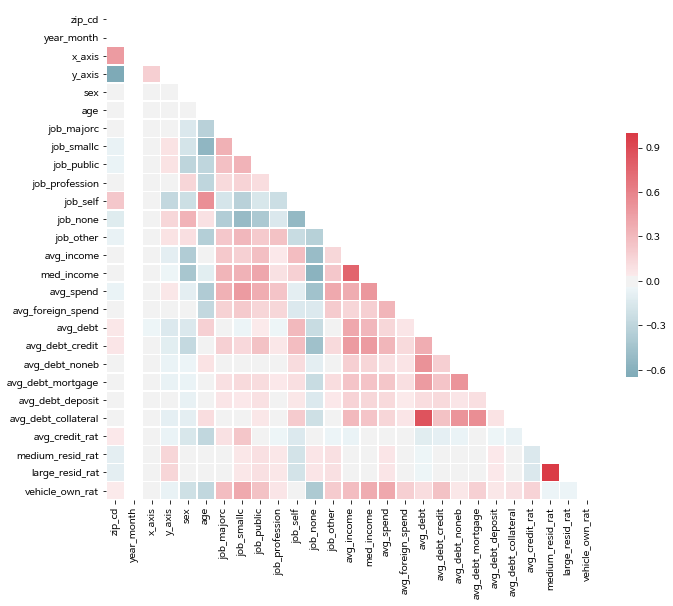

In [6]:
corr = train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show

In [7]:
corr = train[train.columns[4:]].corr().unstack().sort_values(ascending=False).drop_duplicates().drop_duplicates()
corr.drop(corr.index[0],inplace=True)
display(corr.head())
display(corr.tail())

medium_resid_rat     large_resid_rat        1.000000
avg_debt             avg_debt_collateral    0.864224
med_income           avg_income             0.767186
avg_debt_collateral  avg_debt_mortgage      0.537432
job_self             age                    0.533631
dtype: float64

avg_income  job_none   -0.497262
job_smallc  job_none   -0.512313
job_none    job_self   -0.524258
job_smallc  age        -0.551662
med_income  job_none   -0.574243
dtype: float64

상관관계에 따르면 
- 나이가 높을 수록 자영업 비율이 높고,
- 대출이 많을수록 물건담보대출이 높아짐을 확인했으며, 
- 무직의 비율이 높을수록 소득이 낮으며
- 나이가 많을수록 중소기업 근로비율은 낮은것을 확인했다.

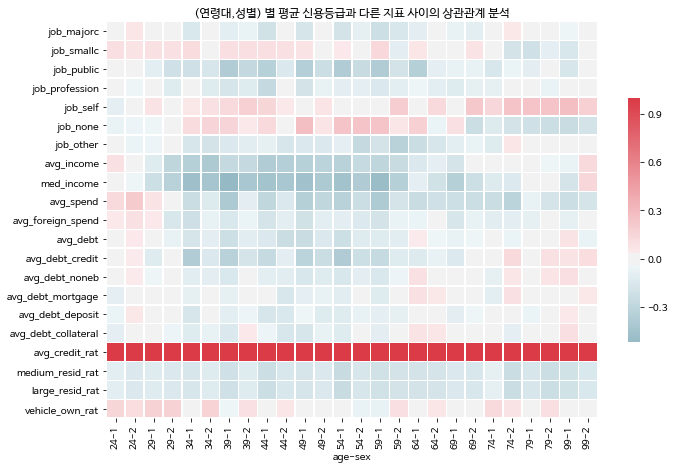

In [8]:
corr = train[train.columns[4:]].groupby(['age', 'sex']).corr()['avg_credit_rat'].fillna(0).unstack()
mask = np.zeros_like(corr, dtype=np.bool)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr.T,  cmap=cmap,  center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('(연령대,성별) 별 평균 신용등급과 다른 지표 사이의 상관관계 분석')
plt.show()

연령대별로 상관관계를 비교했을 때
- 중반대의 나이에서 소득과 신용등급의 연관성이 높은것으로 보이며,
- 여성에서 특히 대형 차량 소유시에 신용등급과 연관이 높은것으로 확인된다.
- 중대형/대형 거주비율은 모든 연령에서 공통적으로 신용등급을 높이는 데 기여하는 것으로 보인다.

Text(0.5,0.98,'등급별 분포')

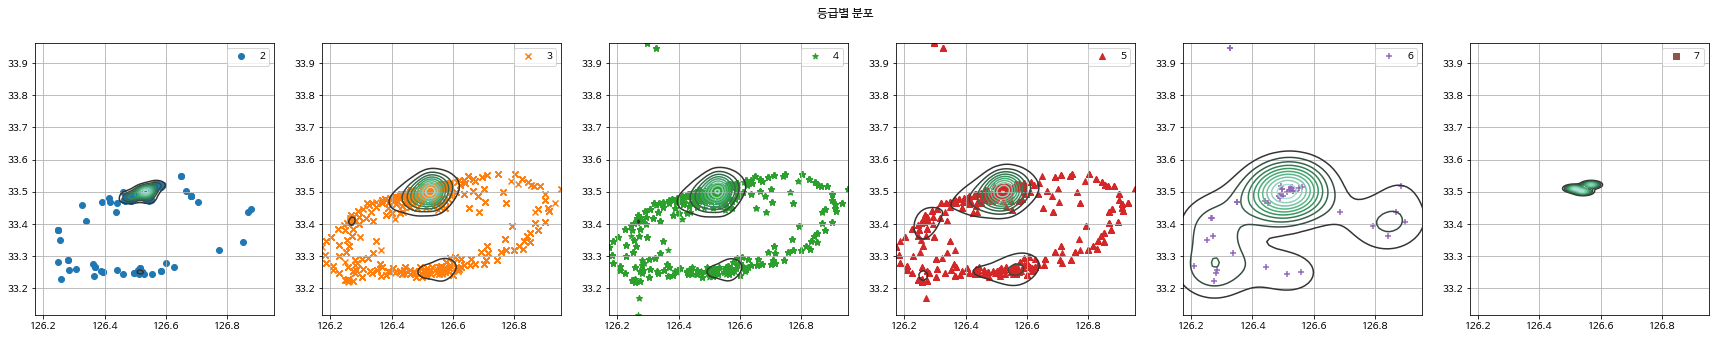

In [9]:
plt.figure(figsize=(30,5))
for i, (rate, marker) in enumerate(zip(np.sort(train.avg_credit_rat.unique()), ['o','x','*','^','+','s'])):
    ax = plt.subplot(1,6,i+1)
    tmp = train.where(train.avg_credit_rat==rate).dropna().groupby('zip_cd').mean()
    sns.kdeplot(tmp[['x_axis', 'y_axis','avg_credit_rat']],ax = ax)
    tmp = train.where(train.avg_credit_rat==rate)
    plt.scatter(tmp.x_axis,tmp.y_axis, marker=marker, label=rate, color='C'+str(i))
    plt.grid()
    plt.legend()
    plt.xlim(train.x_axis.min(),train.x_axis.max())
    plt.ylim(train.y_axis.min(),train.y_axis.max())
plt.suptitle('등급별 분포')

신용 등급별 분포를 보았을 때 구좌읍 근처에는 평균이 2등급인 지역이 없는 것으로 확인된다.  
데이터 중 가장 낮은 등급인 7등급은 제주시 주변의 도시에 거주한다.

## 신용점수 예측모델 학습 및 분석
신용점수를 예측하는 모델을 학습하여 신용도에 영향을 많이 주는 요소를 분석한다.
- 예측 목표: 'avg_credit_rat'
- 학습에 사용되는 요소: 'job_majorc', 'job_smallc', 'job_public', 'job_profession', 'job_self', 'job_none', 'job_other', 'avg_income', 'med_income', 'avg_spend', 'avg_foreign_spend', 'avg_debt', 'avg_debt_credit', 'avg_debt_noneb', 'avg_debt_mortgage', 'avg_debt_deposit', 'avg_debt_collateral', 'medium_resid_rat', 'large_resid_rat', 'vehicle_own_rat'
- 학습에서 제외된 요소: 'zip_cd','year_month','sex','age', 'x_axis','y_axis'

### 변수 중요도 분석
- Feature Importance: 해당 요소가 데이터를 학습 목적에 맞게 얼마나 잘 나누는지
- Permutation Importance: 해당 요소의 값만 다른 샘플과 임의로 바꾸었을 때 예측 성능이 감소하는 정도

In [10]:
from sklearn.model_selection import train_test_split

target = 'avg_credit_rat'
cols_to_drop = ['zip_cd','year_month','sex','age', 'x_axis','y_axis',
                target]
cols_to_fit = [col for col in train.columns if col not in cols_to_drop]
train_split, val_split = train_test_split(train, test_size=0.3)

[0]	validation_0-merror:0.428526
[10]	validation_0-merror:0.383754
[20]	validation_0-merror:0.376399
[30]	validation_0-merror:0.376079
[40]	validation_0-merror:0.376399
[50]	validation_0-merror:0.377039
[60]	validation_0-merror:0.379277
[70]	validation_0-merror:0.37544
[80]	validation_0-merror:0.373841
[90]	validation_0-merror:0.370003
[99]	validation_0-merror:0.372242


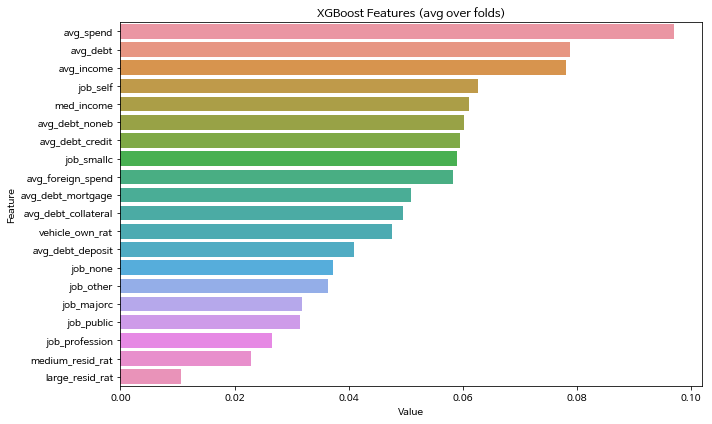

Weight,Feature
0.0610 ± 0.0077,avg_spend
0.0201 ± 0.0074,avg_debt
0.0194 ± 0.0057,avg_debt_collateral
0.0172 ± 0.0079,med_income
0.0159 ± 0.0056,vehicle_own_rat
0.0151 ± 0.0091,avg_debt_noneb
0.0151 ± 0.0085,avg_income
0.0123 ± 0.0083,job_smallc
0.0108 ± 0.0078,job_self
0.0098 ± 0.0048,medium_resid_rat


In [11]:
from xgboost import XGBClassifier
params = {
    'n_estimators': 100,
    'learning_rate': 0.3, 
    'objective':'multi:softmax',
    'num_leaves': 10,
    'verbose': -1,
    'num_class':6
}

xgb_model = XGBClassifier(**params)
xgb_model.fit(
    train_split[cols_to_fit], train_split[target],
    eval_set=[(val_split[cols_to_fit], val_split[target])],
    verbose=10,
)

feature_importance = pd.DataFrame(sorted(zip(xgb_model.feature_importances_, cols_to_fit)), columns=['Value','Feature'])

plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('XGBoost Features (avg over folds)')
plt.tight_layout()
plt.show()

perm = PermutationImportance(xgb_model).fit(val_split[cols_to_fit], val_split[target])
eli5.show_weights(perm, feature_names=list(cols_to_fit))

학습/검증 데이터를 다양하게 분배하고 모델 파라미터를 여러가지로 조정해본 결과 공통적으로 중요하게 여겨지는 변수는
- 소비량(avg_spend)
- 소득 수준(med_income, avg_income)

중요치 않게 여겨지는 변수는
- 주택의 크기(large_resid_rat)
- 담보대출 중 일부(avg_debt_collateral, avg_debt_deposit)

따라서 신용도에는 대출보다는 소비량과 소득의 영향이 크다고 할 수 있다.

### SHAP 중요도 분석
위의 중요도로는 변수가 얼마나 영향을 주는지만 알 수 있을 뿐, 신용도를 높이거나 낮추는 데에는 어떤 영향이 있는지 알 수 없다.
SHAP를 사용해 변수의 값이 높을/낮을 때 신용도가 올라가는지 내려가는지를 보인다.

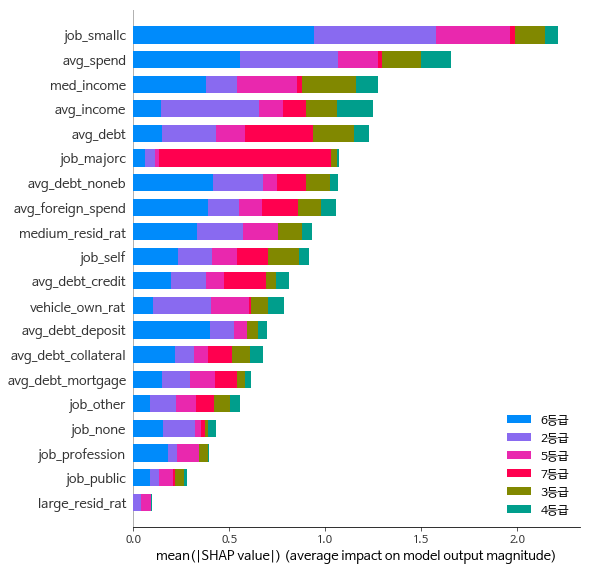

In [12]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(val_split[cols_to_fit])
shap.summary_plot(shap_values, val_split[cols_to_fit], class_names=[str(i)+'등급' for i in range(2,8)])

각 등급에 가장 기여를 많이하는 변수는
- 2등급: avg_income이지만 avg_spend, job_smallc와도 큰 차이가 없다.
- 3등급: med_income으로 역시 소득의 영향이 크다.
- 4등급: 영향이 미미해 구분이 어렵지만 avg_spend와 avg_income의 영향이 크다.
- 5등급: med_income으로 역시 소득의 영향이 크다.
- 6등급: job_smallc가 가장 영향이 크고, 그다음이 avg_spend이다.
- 7등급: job_majorc가 가장 영향이 큰 것이 놀랍다. 대기업에 종사하지만 7등급인 사람이 제주도에 많이 분포하는 것을 해석가능하다.